In [212]:
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import Sequence, to_categorical
from keras.models import load_model
import math
import cv2
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score, f1_score
)

In [213]:
inter_path = os.path.abspath("/src/pesquisa_jovem_cientista/pesquisa_jovem_cientista/MobileNetV2/models/")
metrics_path = os.path.abspath("/src/pesquisa_jovem_cientista/pesquisa_jovem_cientista/MobileNetV2/results/")
csv_path = os.path.abspath("/src/pesquisa_jovem_cientista/pesquisa_jovem_cientista/MobileNetV2/csv/")

used_labels = {"NORMAL": 0, "DRUSEN": 1, "DME": 2, "CNV": 3}

bz = 32

class OCTSequence(Sequence):
    def __init__(self, dataframe, batch_size=bz, augmentate=False, oversampling=False, undersampling=True, inputshape=(224, 224,3), preprocessing_fcn=None):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.augmentate = augmentate
        self.oversampling = oversampling
        self.undersampling = undersampling
        self.inputshape = inputshape
        self.preprocessing_fcn = preprocessing_fcn
    
    def __amount_data__(self):
        labels = self.dataframe['label'].unique()
        quant_data = []

        for label in labels:
            df_lbl = self.dataframe.groupby('label').get_group(label)
            quant_data.append(len(df_lbl))
        
        return (max(quant_data), min(quant_data))
    
    def oversampling_data(self):
        if self.oversampling:

            quant_data, _= self.__amount_data__()
            labels = self.dataframe['label'].unique()
            df_balanced_overspl = pd.DataFrame()

            for label in labels:
                
                # contabilizar o incremento necessário para cada label
                df_label = self.dataframe.groupby('label').get_group(label)
                increment = max(0, quant_data - len(df_label))

                # labels com quantidade menor de instancias
                if len(df_label)*2 < increment:

                    divisaoInteira = increment // len(df_label)
                    resto = increment % len(df_label)

                    i = -1
                    while i < divisaoInteira:
                        duplicate = random.sample(range(len(df_label)), k=len(df_label))
                        df_duplicado = df_label.iloc[duplicate].copy()
                        df_balanced_overspl = pd.concat([df_balanced_overspl, df_duplicado])
                        i += 1
                    
                    if len(df_label) < quant_data:
                        duplicate = random.sample(range(len(df_label)), k=resto)
                        df_duplicado = df_label.iloc[duplicate].copy()
                        df_balanced_overspl = pd.concat([df_balanced_overspl, df_duplicado])

                # labels com quantidade maior de instancias
                elif len(df_label)*2 > increment:
                    duplicate = random.sample(range(len(df_label)), k=increment)
                    df_duplicado = df_label.iloc[duplicate].copy()
                    df_lbl = pd.concat([df_label, df_duplicado])
                    df_balanced_overspl = pd.concat([df_balanced_overspl, df_lbl])

            self.dataframe = df_balanced_overspl
            return df_balanced_overspl
        
    
    def undersampling_data(self):
        if self.undersampling:
            # listagem da labels do dataframe
            labels = self.dataframe['label'].unique()
            _, quant_data = self.__amount_data__()
            df_balanced_underspl = pd.DataFrame()

            for label in labels:
                            
                # contabilizar o incremento necessário para cada label
                df_label = self.dataframe.groupby('label').get_group(label).reset_index()
                decrement = max(0, abs(quant_data - len(df_label)))

                if decrement == 0:
                    df_balanced_underspl = pd.concat([df_balanced_underspl,df_label])
                
                else:
                    dropout = random.sample(list(df_label.index), k=decrement)
                    df_label = df_label.drop(dropout)
                    df_balanced_underspl = pd.concat([df_balanced_underspl,df_label])
            
            self.dataframe = df_balanced_underspl
            return df_balanced_underspl


    def __len__(self):
        return math.ceil(len(self.dataframe) / self.batch_size)
    

    def __getitem__(self, idx):
        batch_x = self.dataframe.iloc[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]["file_path"].values
      
        batch_y = self.dataframe.iloc[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]["label"].values

        batch_y = to_categorical(
            [used_labels[i] for i in batch_y], num_classes=len(used_labels.keys())
        )

        return np.array(
            [self.preprocess(cv2.imread(file_name)) for file_name in batch_x]
        ), np.array(batch_y)
    

    def preprocess(self, image):
        if self.augmentate:
            rotation_angle = np.random.randint(low=-15, high=15)
            
            rotmat = cv2.getRotationMatrix2D(
                (image.shape[1] // 2, image.shape[0] // 2), rotation_angle, 1
            )
            

            image = cv2.warpAffine(
                src=image,
                M=rotmat,
                dsize=(image.shape[1], image.shape[0]),
                borderMode=cv2.BORDER_REFLECT,
            )

            # flips
            if np.random.randint(low=0, high=2):
                image = np.fliplr(image)
            if np.random.randint(low=0, high=2):
                image = np.flipud(image)

            #cropping
            center = np.array(image.shape) / 2
            xc = int(center[1] - image.shape[1]/2)
            yc = int(center[0] - image.shape[0]/2)
            x = image[yc:yc+int(0.7*image.shape[0]), xc:xc+int(0.7*image.shape[1])]   
            x = cv2.resize(x, self.inputshape[:-1])

        else:
            #cropping
            center = np.array(image.shape) / 2
            xc = int(center[1] - image.shape[1]/2)
            yc = int(center[0] - image.shape[0]/2)
            x = image[yc:yc+int(0.7*image.shape[0]), xc:xc+int(0.7*image.shape[1])]   
            x = cv2.resize(x, self.inputshape[:-1])
        
        if self.preprocessing_fcn is None:
            x -= 127.0
            x /= 127.0
        else:
            x = x.astype(np.uint8)
            x = self.preprocessing_fcn(x)

        return x

    def on_epoch_end(self):
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)


In [214]:
# load the train dataset
train_data_path = os.path.abspath("/data/ZhangLabData/CellData/OCT/train") # /data/ZhangLabData/CellData/OCTtrain
filelist_train = []

for root, dirs, files in os.walk(train_data_path):
        for file in files:
            # append the file name to the list
            filelist_train.append(os.path.join(root, file))
diseases = [i.split("-")[0].split("/")[-1] for i in filelist_train]
patient = [i.split("-")[1] for i in filelist_train]
image_nb = [i.split("-")[-1] for i in filelist_train]

df_train = pd.DataFrame(
        data={
            "label": diseases,
            "patient": patient,
            "image_nb": image_nb,
            "file_path": filelist_train,
        }
    )

print("\n found {} training images...".format(len(df_train)))

#split the training and validation datasets
train_val_split_mode = "patient"
train_val_split_rate = 0.2

if train_val_split_mode == "patient":
        # Get unique patient IDs
        patient_ids = df_train["patient"].unique()
        # Split patient IDs into training and validation sets
        train_ids, val_ids = train_test_split(patient_ids, test_size=train_val_split_rate, random_state=42)

        # Create training and validation dataframes based on patient IDs
        df_new_train = df_train[df_train["patient"].isin(train_ids)]
        df_val = df_train[df_train["patient"].isin(val_ids)]
        df_train = df_new_train

print("\n found {} validation images...".format(len(df_val)))

# load the test dataset
test_data_path = os.path.abspath("/data/ZhangLabData/CellData/OCT/test")
filelist_test = []

for root, dirs, files in os.walk(test_data_path):
        for file in files:
            # append the file name to the list
            filelist_test.append(os.path.join(root, file))
diseases = [i.split("/")[-2] for i in filelist_test]
patient = [i.split("-")[-2] for i in filelist_test]
image_nb = [i.split("-")[-1] for i in filelist_test]

df_test = pd.DataFrame(
        data={
            "label": diseases,
            "patient": patient,
            "image_nb": image_nb,
            "file_path": filelist_test,
        }
    )
print("\n found {} test images...".format(len(df_test)))


 found 108309 training images...

 found 22701 validation images...

 found 1000 test images...


/tmp/ipykernel_4608/3690080719.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label',data=df_train,palette="pastel")


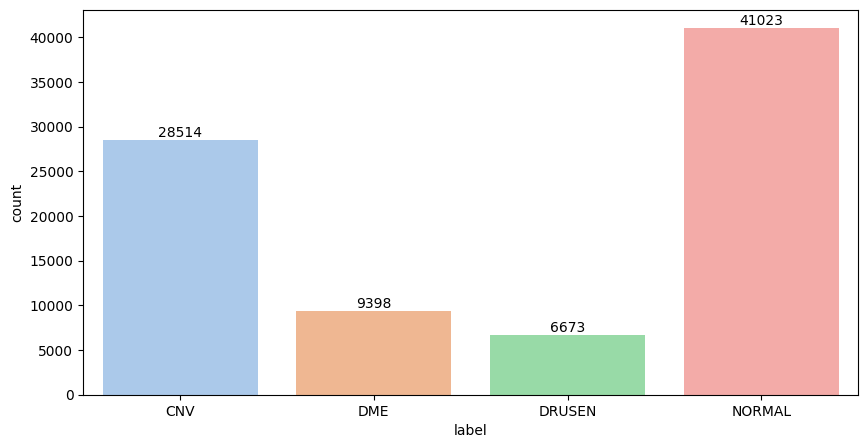

In [215]:
" Amostra de distribuição dos dados originais"

plt.figure(figsize=(10,5))
ax = sns.countplot(x='label',data=df_train,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [216]:
#NÚMERO DE IMAGENS EM CADA CONJUNTO
print('Training set has {} images from {} patients'.format(len(df_train),df_train.patient.nunique()))
print('Validation set has {} images from {} patients'.format(len(df_val),df_val.patient.nunique()))
print('Test set has {} images from {} patients'.format(len(df_test),df_test.patient.nunique()))
print()

#CASOS DE VAZAMENTO DE DADOS
print('There are {} patients that are both in training and test sets.'.format(len(set(df_train.patient) & set(df_test.patient))))
print('There are {} patients that are both in training and validation sets.'.format(len(set(df_train.patient) & set(df_val.patient)))) 
print('There are {} patients that are both in validation and test sets.'.format(len(set(df_test.patient) & set(df_val.patient))))
print('There are {} patients that are both in validation test and train sets.'.format(len(set(df_test.patient) & set(df_val.patient) & set(df_train.patient))))
print()

Training set has 85608 images from 3828 patients
Validation set has 22701 images from 957 patients
Test set has 1000 images from 635 patients

There are 0 patients that are both in training and test sets.
There are 0 patients that are both in training and validation sets.
There are 0 patients that are both in validation and test sets.
There are 0 patients that are both in validation test and train sets.



In [217]:
# "Amostra dos dados balanceados"

# df_seq = OCTSequence(df_train, batch_size=32, augmentate=True, oversampling=True, undersampling=False, inputshape=(224, 224,3), preprocessing_fcn=None)
# df_train = df_seq.oversampling_data()

# plt.figure(figsize=(10,5))
# ax = sns.countplot(x='label',data=df_train,palette="pastel")
# for i in ax.containers:
#     ax.bar_label(i,)

In [218]:
#NÚMERO DE IMAGENS EM CADA CONJUNTO
print('Training set has {} images from {} patients'.format(len(df_train),df_train.patient.nunique()))
print('Validation set has {} images from {} patients'.format(len(df_val),df_val.patient.nunique()))
print('Test set has {} images from {} patients'.format(len(df_test),df_test.patient.nunique()))
print()

#CASOS DE VAZAMENTO DE DADOS
print('There are {} patients that are both in training and test sets.'.format(len(set(df_train.patient) & set(df_test.patient))))
print('There are {} patients that are both in training and validation sets.'.format(len(set(df_train.patient) & set(df_val.patient)))) 
print('There are {} patients that are both in validation and test sets.'.format(len(set(df_test.patient) & set(df_val.patient))))
print('There are {} patients that are both in validation test and train sets.'.format(len(set(df_test.patient) & set(df_val.patient) & set(df_train.patient))))
print()

Training set has 85608 images from 3828 patients
Validation set has 22701 images from 957 patients
Test set has 1000 images from 635 patients

There are 0 patients that are both in training and test sets.
There are 0 patients that are both in training and validation sets.
There are 0 patients that are both in validation and test sets.
There are 0 patients that are both in validation test and train sets.



In [219]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #base_model.load_weights("/data/models/mobilenet_v2_weights.h5")
preprocessing_fcn = tf.keras.applications.mobilenet_v2.preprocess_input

# Create a new model
model = Sequential()
# Add the pre-trained model to the new model
model.add(base_model)
# Add a flatten layer to the new model
model.add(Flatten())
# Add a dense layer with 4 outputs to the new model
model.add(Dense(4, activation="softmax"))
input_shape = model.layers[0].input_shape[1:]

        
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #         loss=tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence"),
    #          metrics=[tf.keras.metrics.CategoricalAccuracy("accuracy"),
    #                   tf.keras.metrics.AUC(name="auc")])


df_val = df_val.sample(frac=1).reset_index(drop=True)
val_seq = OCTSequence(
    df_val,
    batch_size=bz,
    augmentate=False,
    oversampling=False,
    undersampling=True,
    inputshape=input_shape,
    preprocessing_fcn=preprocessing_fcn,
)

df_train = df_train.sample(frac=1).reset_index(drop=True)
train_seq = OCTSequence(
    df_train,
    batch_size=bz,
    augmentate=False,
    oversampling=False,
    undersampling=True,
    inputshape=input_shape,
    preprocessing_fcn=preprocessing_fcn,
)
    
    
# Compile the model
model.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC"],
)
model_path = os.path.join(inter_path,f"modelo_mobilenet_{bz}_noAUG_under.keras")
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, monitor="val_loss", save_best_only=True
    )
]       

historico = model.fit(
    train_seq,
    validation_data=val_seq,
    steps_per_epoch=len(train_seq)//(10),
    epochs=100,
    callbacks=my_callbacks,
    verbose=1,
    workers=10,
        )

Epoch 1/100
267/267 [==============================] - 92s 328ms/step - loss: 0.8468 - accuracy: 0.8301 - auc: 0.9495 - val_loss: 18.3401 - val_accuracy: 0.4459 - val_auc: 0.6308
Epoch 2/100
267/267 [==============================] - 60s 223ms/step - loss: 0.3274 - accuracy: 0.9030 - auc: 0.9812 - val_loss: 10.0250 - val_accuracy: 0.4476 - val_auc: 0.6371
Epoch 3/100
267/267 [==============================] - 60s 223ms/step - loss: 0.2294 - accuracy: 0.9238 - auc: 0.9895 - val_loss: 5.8578 - val_accuracy: 0.4978 - val_auc: 0.7012
Epoch 4/100
267/267 [==============================] - 60s 222ms/step - loss: 0.1948 - accuracy: 0.9355 - auc: 0.9916 - val_loss: 1.9910 - val_accuracy: 0.7287 - val_auc: 0.8803
Epoch 5/100
267/267 [==============================] - 60s 224ms/step - loss: 0.1829 - accuracy: 0.9421 - auc: 0.9924 - val_loss: 1.5178 - val_accuracy: 0.7603 - val_auc: 0.9021
Epoch 6/100
267/267 [==============================] - 59s 221ms/step - loss: 0.1772 - accuracy: 0.9415 - au

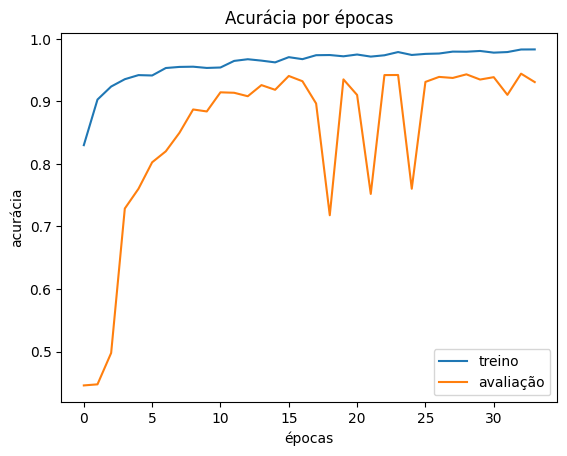

In [220]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino','avaliação'])
plt.savefig(os.path.join(metrics_path,f"acc_per_epoch_{bz}_noAUG_under"))

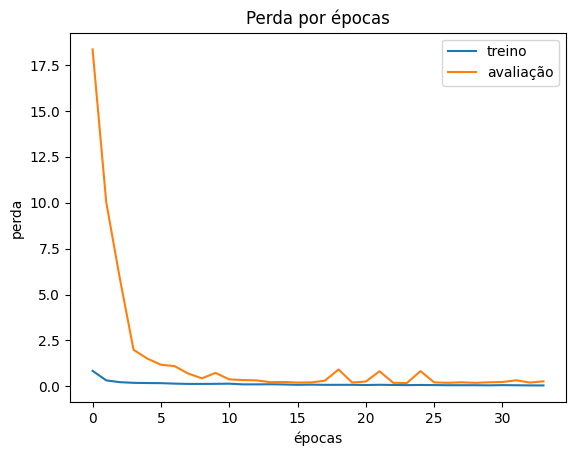

In [221]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino','avaliação'])
plt.savefig(os.path.join(metrics_path,f"loss_per_epoch_{bz}_noAUG_under"))

In [222]:
# Testing

used_labels_contrary = {v: k for k, v in used_labels.items()}
input_shape = model.layers[0].input_shape[1:]
# Load the true labels for the test sequence

y_true = df_test["label"].values
y_true = np.array([used_labels[i] for i in y_true])

# Get the predicted probabilities for each class
test_seq = OCTSequence(
        df_test,
        batch_size=bz,
        augmentate=False,
        oversampling=False,
        undersampling=False,
        inputshape=input_shape,
        preprocessing_fcn=preprocessing_fcn,
    )

y_pred_prob = model.predict(test_seq)

# Get the predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# transform y_pred from numerical labels to string labels
y_pred_labels = [used_labels_contrary[i] for i in y_pred]
# put the predicted labels in the dataframe
df_test["predicted_label"] = y_pred_labels

32/32 [==============================] - 19s 589ms/step


In [223]:
# Get the classification report
class_names = np.array(list(used_labels.keys()))
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

# Get the AUC for each class
auc_scores = []
for i in range(len(class_names)):
        y_true_i = (y_true == i).astype(int)
        y_pred_prob_i = y_pred_prob[:, i]
        auc_i = roc_auc_score(y_true_i, y_pred_prob_i)
        auc_scores.append(auc_i)

# Get the accuracy, sensitivity, and specificity for each class
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
for i in range(len(class_names)):
        y_true_i = (y_true == i).astype(int)
        y_pred_i = (y_pred == i).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true_i, y_pred_i).ravel()
        accuracy_i = accuracy_score(y_true_i, y_pred_i)
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        accuracy_scores.append(accuracy_i)
        sensitivity_scores.append(sensitivity_i)
        specificity_scores.append(specificity_i)
print()

# Print the classification report, AUC scores, accuracy scores, sensitivity scores, and specificity scores
print(report)
for i in range(len(class_names)):
        print("AUC for", class_names[i], ":", auc_scores[i])
        print("Accuracy for", class_names[i], ":", accuracy_scores[i])
        print("Sensitivity for", class_names[i], ":", sensitivity_scores[i])
        print("Specificity for", class_names[i], ":", specificity_scores[i])
        print()


              precision    recall  f1-score   support

      NORMAL     0.9575    0.9920    0.9745       250
      DRUSEN     0.9792    0.7520    0.8507       250
         DME     1.0000    0.9040    0.9496       250
         CNV     0.7678    0.9920    0.8656       250

    accuracy                         0.9100      1000
   macro avg     0.9261    0.9100    0.9101      1000
weighted avg     0.9261    0.9100    0.9101      1000

AUC for NORMAL : 0.9980800000000001
Accuracy for NORMAL : 0.987
Sensitivity for NORMAL : 0.992
Specificity for NORMAL : 0.9853333333333333

AUC for DRUSEN : 0.9633546666666666
Accuracy for DRUSEN : 0.934
Sensitivity for DRUSEN : 0.752
Specificity for DRUSEN : 0.9946666666666667

AUC for DME : 0.9963413333333333
Accuracy for DME : 0.976
Sensitivity for DME : 0.904
Specificity for DME : 1.0

AUC for CNV : 0.989984
Accuracy for CNV : 0.923
Sensitivity for CNV : 0.992
Specificity for CNV : 0.9



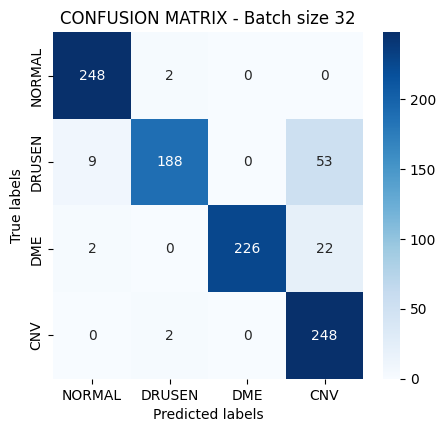

In [224]:
# plot de confusion matrix

cf_matrix = confusion_matrix(y_true, y_pred)

labels = ["NORMAL", "DRUSEN", "DME", "CNV"]

plt.figure(figsize=(5, 4.5))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=True, linecolor='k',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title(f"CONFUSION MATRIX - Batch size {bz}")
plt.savefig(os.path.join(metrics_path,f"confusion_mat_{bz}_noAUG_under"))
plt.show()

# NORMAL: 0, DRUSEN: 1, DME: 2, CNV: 3

In [225]:
# resultados individuais

df_resultado_individual = pd.DataFrame(y_pred_prob)
df_resultado_individual = pd.DataFrame(y_pred_prob, columns=["NORMAL", "DRUSEN", "DME", "CNV"])
df_resultado_individual = df_resultado_individual.round(3)
df_resultado_individual.to_csv(os.path.join(csv_path, f"model_mobilenet_{bz}_noAUG_under.csv") , index=True)
df_resultado_individual

,NORMAL,DRUSEN,DME,CNV
0,0.012,0.241,0.0,0.747
1,0.000,0.000,0.0,1.000
2,0.000,0.000,0.0,1.000
3,0.000,0.000,0.0,1.000
4,0.000,0.000,0.0,1.000
...,...,...,...,...
995,0.999,0.001,0.0,0.000
996,0.957,0.043,0.0,0.000
997,0.999,0.001,0.0,0.000
998,0.998,0.002,0.0,0.000
